In [6]:
"""Propagating 2D dynamics on the muller potential using OpenMM.
Currently, we just put a harmonic restraint on the z coordinate,
since OpenMM needs to work in 3D. This isn't really a big deal, except
that it affects the meaning of the temperature and kinetic energy. So
take the meaning of those numbers with a grain of salt.
"""
from openmm.unit import kelvin, picosecond, femtosecond, nanometer, dalton
import openmm as mm

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

from energy_landscape import MullerForce, ModifiedMullerForce, landscape
import algorithm

import scipy.stats as st
# from matplotlib.path import Path
# from scipy.stats import gaussian_kde

from sys import getsizeof

In [3]:
class ObsBoundReInit3():
    '''
    Adam-inspired reinitialization method
    Direction of update is determined by the gradient density
    '''
    def __init__(self, traj, cent_prev, delta, beta, k):
        self.traj = traj 
        self.delta = delta
        self.beta = beta
        self.k = k 
        self.x = traj[1:,0] # not considering init point
        self.y = traj[1:,1] # not considering init point
        self.cent = np.array([[self.x.mean()], [self.y.mean()]])
        self.cent_prev = cent_prev
        self.init = np.array([[traj[0,0]], [traj[0,1]]]) 
        self.last = np.array([[self.x[-1]], [self.y[-1]]]) 

    
    def kde(self):
        x, y = self.x, self.y
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        return kernel
    
    def contour(self):
        x, y = self.x, self.y
        # Define the borders
        deltaX = (max(x) - min(x))/10
        deltaY = (max(y) - min(y))/10
        xmin = min(x) - deltaX
        xmax = max(x) + deltaX
        ymin = min(y) - deltaY
        ymax = max(y) + deltaY
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        pos = np.vstack([xx.ravel(), yy.ravel()])
        f = np.reshape(self.kde()(pos).T, xx.shape)
        levels = np.linspace(min(f.flatten()), max(f.flatten()), 10)
        contours = plt.contour(xx,yy, f, levels=levels)
        plt.scatter(self.cent_prev[0], self.cent_prev[1])
        return contours

    def density_gradient(self, point, kde):
        dx = point + np.array([[self.delta],[0]])
        dy = point + np.array([[0],[self.delta]])
        
        f = kde(point)
        f_dx = kde(dx)
        f_dy = kde(dy)

        grad = np.array([(f_dx - f)/self.delta, (f_dy - f)/self.delta])
        return grad 
    

    def get_contour_path(self, target_fraction):
        n_points = len(self.traj)
        x, y = self.x, self.y
        contours = self.contour()
        
        # Initialize the variables to find the contour that contains more than 50% of the data
        contour_index = 0
        # Loop over the contour lines to find the one that contains more than 50% of the data
        for i, contour in enumerate(contours.collections):
            path = contour.get_paths()[0]
            points_inside_contour = sum(path.contains_points(np.stack([x, y]).T))
            if (points_inside_contour > 0) and (points_inside_contour <= n_points * target_fraction):
                contour_index = i
                break
        # Get the coordinates of the contour that contains more than 50% of the data
        path = contours.collections[contour_index].get_paths()[0]
        x_values = path.vertices[:,0]
        y_values = path.vertices[:,1]
        plt.plot(x_values, y_values, color='red', ls='--')
        return path
    
    def determine_revisit(self, path_list, cent_prev):
        # return >=1 -> no new cluster
        # return 0   -> new cluster
        is_inside = 0
        for path in path_list:
            is_inside += int(path.contains_point(cent_prev))
        return is_inside

    def select_boundary_kde(self, path_list, kde_list, cent_prev):
        # iteration starts from the recent boundary path
        # this can be combined with determine_revisit function
        for i, path in enumerate(path_list[::-1]):
            
            is_inside = path.contains_point(cent_prev)
            if is_inside:
                break
        #idx = len(path_list) - i
        kde = kde_list[::-1][i]
        return path, kde      
    
    def increase(self, vn):
        #g = self.gamma(path_list, cent_prev)
        return vn + 1
    

    def update_position(self, grad, vn):
        numer = self.beta * (1 + self.increase(vn)/self.k)
        denorm = np.sqrt(np.sum(grad**2)+0.0001)
        update = -numer/denorm * grad
        update_rate = np.sqrt(np.sum(update**2))
        return self.last + update, update_rate

1 outer step: 500   | cent: [0.61 0.2 ]
    inner step: 600 | cent: [0.61 0.2 ] | init: [0.61 0.27] |  v_n: 2 | update: 0.3
    inner step: 800 | cent: [0.61 0.21] | init: [0.29 0.69] |  v_n: 6 | update: 0.6
    inner step: 1000 | cent: [-0.46 -0.48] | init: [-0.04  0.31] |  v_n: 10 | update: 0.9
2 outer step: 1500   | cent: [-0.47 -0.46]
    inner step: 1600 | cent: [-0.48 -0.46] | init: [-0.61 -0.29] |  v_n: 2 | update: 0.3
    inner step: 1800 | cent: [0.56 0.21] | init: [0.44 0.75] |  v_n: 6 | update: 0.6
    inner step: 1900 | cent: [-0.47 -0.46] | init: [-0.25  0.18] |  v_n: 8 | update: 0.75
    inner step: 2000 | cent: [-0.48 -0.45] | init: [-1.18 -0.56] |  v_n: 10 | update: 0.9
    inner step: 2150 | cent: [0.6 0.2] | init: [0.71 1.37] |  v_n: 13 | update: 1.12
    inner step: 2200 | cent: [0.54 0.23] | init: [1.05 1.32] |  v_n: 14 | update: 1.2
    inner step: 2400 | cent: [0.56 0.24] | init: [-0.49  1.08] |  v_n: 18 | update: 1.5
    inner step: 2450 | cent: [-0.55 -0.23] | i

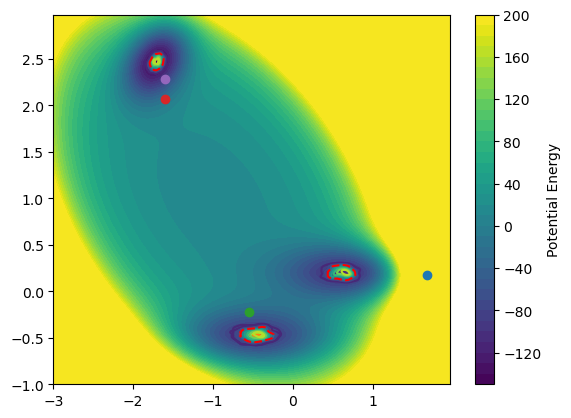

In [4]:
np.random.seed(1)

# Update Algorithm Parameters
total_step = 5000
large_batch_size = 500
small_batch_size = 50
beta = 0.15 
k = 2.0
boundary_frac = 0.75 

# Brownian simulation parameters
## each particle is totally independent, propagating under the same potential
nParticles = 1  
mass = 1.0 * dalton
temp = 750
temperature = temp * kelvin
friction = 100 / picosecond
timestep = 10.0 * femtosecond
## Define initial point
sp_A = (np.random.rand(1, 3) * np.array([0.2, 0.1, 1])) + np.array([1.6, 0.1, 0])
startingPositions = sp_A 

# Brownian simulation set-up
system = mm.System()
pes = landscape('Modified_Muller')

for i in range(nParticles):
    system.addParticle(mass)
    pes.addParticle(i, [])
system.addForce(pes)

integrator = mm.LangevinIntegrator(temperature, friction, timestep)
context = mm.Context(system, integrator)

# Preparation to run simulations
traj_save = []
path_save = []
kde_save = []
init_points = []
update_rates = []
iteration_counter={}
cent = startingPositions[:,:2].T 
v = 0
#########################

ft=15
pes.plot(ax=plt.gca())

# Start simulation
remain_step = total_step
n=1 
while remain_step > 0:
    # Initialization
    context.setPositions(startingPositions)
    context.setVelocitiesToTemperature(temperature)
    init_points.append(startingPositions[0][:2])
    
    # Outer iteration (Browninan Simulation)
    traj = np.zeros((large_batch_size,3))
    for i in range(large_batch_size):
        x = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)   
        p = x[0]
        E = pes.potential(x=p[0], y=p[1])
        traj[i] = np.array([p[0], p[1], E])
        integrator.step(100)
    traj_save.append(traj)
    
    # Instantiation
    # particle_outer = ObsBoundReInit3(traj, cent_prev = cent, 
    #                                 delta=0.0001, beta=beta, k=k)
    particle_outer = algorithm.ObsBoundReInit(traj, cent_prev=cent, 
                                              delta=0.0001, beta=beta, k=k)
    
    # Secure boundary & centroid & last point & kernel (density gradient)
    boundary_path = particle_outer.get_contour_path(target_fraction=boundary_frac)
    path_save.append(boundary_path)
    kde = particle_outer.kde()
    kde_save.append(kde)
    cent = particle_outer.cent
    last = particle_outer.last
        
    remain_step -= large_batch_size
    # print results
    print(f'{n} outer step: {total_step-remain_step}   | cent: {np.round(cent.flatten(),2)}')

    # Decision block 
    ## Determine whether the centroid inside any boundary paths 
    ## Start inner loop after the decision
    ## If the centroid is outside all boundary paths, this while loop would be skipped!
    m=0
    while particle_outer.determine_revisit(path_save, cent) != 0:
        # Instantiation
        # particle_inner = ObsBoundReInit3(traj, cent_prev = cent, 
        #                                 delta=0.0001, beta=beta, k=k)
        particle_inner = algorithm.ObsBoundReInit(traj, cent_prev=cent, 
                                                  delta=0.0001, beta=beta, k=k)
        
        # Select boundary_path and kde from the stored ones
        ## Search is conducted from the most recent path
        boundary_path, kde = particle_inner.select_boundary_kde(path_save, kde_save, cent)
              
        # Update reinitialization point
        ## Update rate is amplified by the number of times the centroid is revisited
        density_grad = particle_inner.density_gradient(point=last, kde=kde)
        p_new, upd = particle_inner.update_position(grad=density_grad, vn=v) 
        E_new = pes.potential(*p_new)
        startingPositions = np.vstack((p_new, E_new)).T
        
        # Save update rate for tracking 
        update_rates.append(upd)

        # Re-Initialization
        context.setPositions(startingPositions)
        context.setVelocitiesToTemperature(temperature)       
        
        # Inner iteration (Run Brownian Simulation)
        traj = np.zeros((small_batch_size,3))
        for i in range(small_batch_size):
            x = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)   
            p = x[0]
            E = pes.potential(x=p[0], y=p[1])
            traj[i] = np.array([p[0], p[1], E]) 
            integrator.step(100)
        
        # Secure centroid & last point & v_n for the next run
        v += 1 #= particle_inner.increase(v)     
        cent = particle_inner.cent
        last = particle_inner.last
        
        remain_step -= small_batch_size
        # print results
        if (remain_step%200 == 0) or (boundary_path.contains_point(cent) == False):
            print(f'    inner step: {total_step-remain_step} | cent: {np.round(cent.flatten(),2)} | \
init: {np.round(startingPositions[0][:2],2)} |  v_n: {v} | update: {np.round(upd,2)}')
        
        m+=1
        iteration_counter.update({n:m})
        if remain_step < 0:
            print('reached the max step')
            break
            
    # Reset v_n & init point 
    ## init point as last traj from newly found cluster  
    v=0 
    p_new = last #cent #particle.update_position()
    E_new = pes.potential(*p_new)
    startingPositions = np.vstack((p_new, E_new)).T
    n+=1

if np.sum(list(iteration_counter.values())) == len(update_rates):
    print('itertation number matching!!') 
else:
    print('iteration number NOT matching!!')
    

In [5]:
print(getsizeof(traj_save))
print(getsizeof(path_save))
print(getsizeof(kde_save))

120
120
120


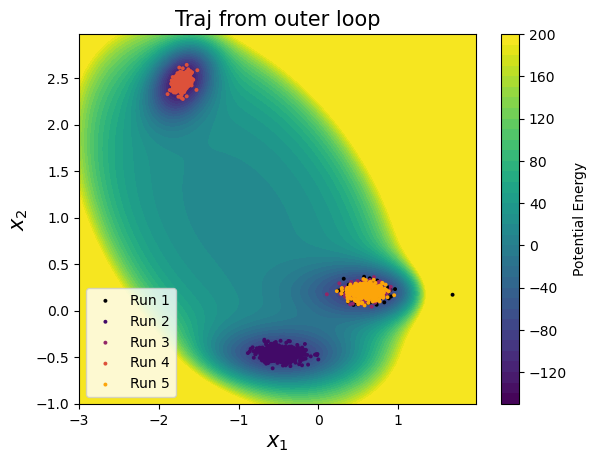

In [74]:
ft=15
e=0.2
traj_all = np.vstack(traj_save)
min_x, max_x = min(traj_all[:,0]), max(traj_all[:,0])
min_y, max_y = min(traj_all[:,1]), max(traj_all[:,1])
pes.plot(ax=plt.gca())
colors = cm.inferno(np.linspace(0, 0.8, len(traj_save)))
i=0
for n in range(len(traj_save)): 
    c = colors[n]
    x = traj_save[n][:,0]
    y = traj_save[n][:,1]
    plt.scatter(x, y, edgecolor='none', s=8, color=c, label=f'Run {i+1}')
    i += 1
plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.title('Traj from outer loop', fontsize=ft)
plt.legend(fontsize=ft-5, loc='lower left')
#plt.savefig(f'./figure/0403/dw_obsbd2_i{total_step}lb{large_batch_size}sb{small_batch_size}b{beta}k{k}.png', bbox_inches='tight', facecolor='w')
plt.show()

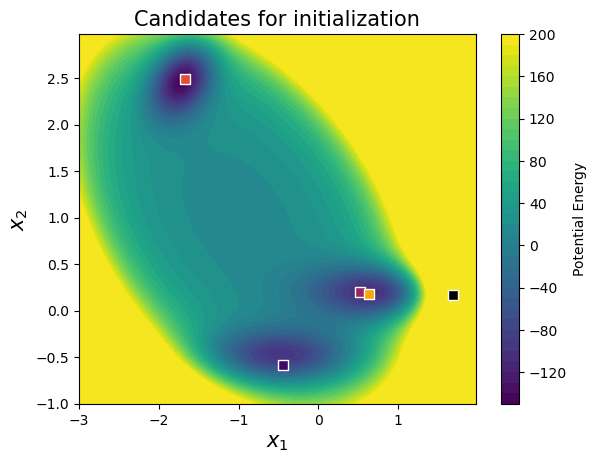

In [75]:
ft=15
e=0.2
traj_all = np.vstack(traj_save)
min_x, max_x = min(traj_all[:,0]), max(traj_all[:,0])
min_y, max_y = min(traj_all[:,1]), max(traj_all[:,1])
pes.plot(ax=plt.gca())
colors = cm.inferno(np.linspace(0, 0.8, len(init_points)))
i=0
for n in range(len(init_points)): 
    c = colors[n]
    x = init_points[n][0]
    y = init_points[n][1]
    plt.scatter(x, y, edgecolor='white', s=50, marker='s', color=c, label=f'Init cand {i+1}')
    i += 1
plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.title('Candidates for initialization', fontsize=ft)
#plt.legend(fontsize=ft-5, loc='lower left')
#plt.savefig(f'./figure/0327/dw_obsbd2_i{total_step}lb{large_batch_size}sb{small_batch_size}b{beta}k{k}.png', bbox_inches='tight', facecolor='w')
plt.show()

Text(0, 0.5, 'Update Rate')

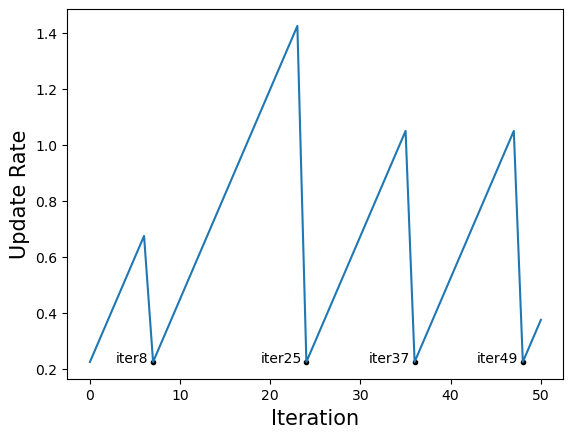

In [76]:
plt.plot(update_rates)
reset_index=[]
for i in range(1, len(update_rates)):
    if update_rates[i] < update_rates[i-1]:
        reset_index.append(i-1)
        plt.scatter(i, update_rates[i], c='k', marker='.')
        plt.text(i-0.5, update_rates[i], f'iter{i+1}', 
                 horizontalalignment='right')
plt.xlabel('Iteration', fontsize=ft)
plt.ylabel('Update Rate', fontsize=ft)
#plt.savefig(f'./figure/0327/doublewell_rate_i{iteration}bs{batch_size}b{beta}k{k}.png', bbox_inches='tight', facecolor='w')